
### Learnable Upsampling with Transpose Convolution

In [0]:
from keras.datasets import mnist
from keras.layers import *
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential,Model
from keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')

In [37]:
(X_Train,_),(_,_) = mnist.load_data()
X_Train = X_Train.reshape((*X_Train.shape,1))
print(X_Train.shape)

(60000, 28, 28, 1)


#### Data Normalization

In [38]:
X_Train = (X_Train.astype('float32')-127.5)/127.5
print(np.min(X_Train))
print(np.max(X_Train))

-1.0
1.0


In [0]:
TOTAL_EPOCHS = 50
BATCH_SIZE = 256
NO_OF_BATCHES = int(X_Train.shape[0]/BATCH_SIZE)
HALF_BATCH = 128
NOISE_DIM = 100
ADAM = Adam(lr=2e-4,beta_1=0.5)

#### Generator (Learnable Upsampling)

In [40]:
generator = Sequential()
# Input : 7 x 7 x 128
generator.add(Dense(7*7*128,input_shape=(NOISE_DIM,)))
generator.add(Reshape((7,7,128)))
generator.add(LeakyReLU(0.2))
generator.add(BatchNormalization())
# Double the Activation size : 14 x 14 x 64
generator.add(Conv2DTranspose(64,kernel_size=(5,5),strides=(2,2),padding='same'))
generator.add(LeakyReLU(0.2))
generator.add(BatchNormalization())
# Double the Activation size : 28 x 28 x 1
generator.add(Conv2DTranspose(1,kernel_size=(5,5),strides=(2,2),padding='same',activation='tanh'))
generator.compile(loss='binary_crossentropy',optimizer=ADAM)
generator.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 6272)              633472    
_________________________________________________________________
reshape_8 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
leaky_re_lu_23 (LeakyReLU)   (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 7, 7, 128)         512       
_________________________________________________________________
conv2d_transpose_13 (Conv2DT (None, 14, 14, 64)        204864    
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 14, 14, 64)      

#### Discriminator (Downsampling)

In [41]:
discriminator = Sequential()
discriminator.add(Conv2D(64,(5,5),strides=(2,2),padding='same',input_shape=(28,28,1)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Conv2D(128,(5,5),strides=(2,2),padding='same'))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Flatten())
discriminator.add(Dense(1,activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy',optimizer=ADAM)
discriminator.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_25 (LeakyReLU)   (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_26 (LeakyReLU)   (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 6273      
Total params: 212,865
Trainable params: 212,865
Non-trainable params: 0
_______________________________________________

### DC-GAN

In [0]:
discriminator.trainable = False
gan_input = Input(shape=(NOISE_DIM,))
generated_img = generator(gan_input)
gan_output = discriminator(generated_img)
# Functional API
model = Model(gan_input,gan_output)
model.compile(loss='binary_crossentropy',optimizer=ADAM)

### Visualize

In [0]:
def save_imgs(epoch,samples=100):
  noise = np.random.normal(0,1,size=(samples,NOISE_DIM))
  generated_imgs = generator.predict(noise)
  generated_imgs = generated_imgs.reshape(samples,28,28)
  plt.figure(figsize=(10,10))
  for i in range(samples):
    plt.subplot(10,10,i+1)
    plt.imshow(generated_imgs[i],interpolation='nearest',cmap='gray')
    plt.axis('off')
  plt.tight_layout()
  plt.show()

### Training

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch : 1, Discriminator Loss : 0.6687, Generator Loss : 1.0304
Epoch : 2, Discriminator Loss : 0.7000, Generator Loss : 0.8669
Epoch : 3, Discriminator Loss : 0.6845, Generator Loss : 0.8653
Epoch : 4, Discriminator Loss : 0.6847, Generator Loss : 0.8561
Epoch : 5, Discriminator Loss : 0.6905, Generator Loss : 0.8404
Epoch : 6, Discriminator Loss : 0.6917, Generator Loss : 0.8311
Epoch : 7, Discriminator Loss : 0.6912, Generator Loss : 0.8260
Epoch : 8, Discriminator Loss : 0.6908, Generator Loss : 0.8224
Epoch : 9, Discriminator Loss : 0.6900, Generator Loss : 0.8213
Epoch : 10, Discriminator Loss : 0.6898, Generator Loss : 0.8192


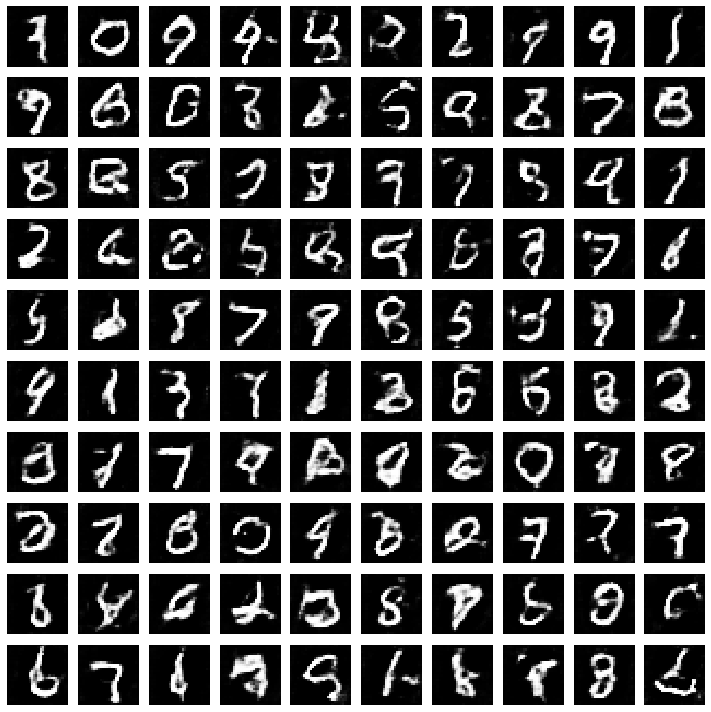

Epoch : 11, Discriminator Loss : 0.6894, Generator Loss : 0.8185
Epoch : 12, Discriminator Loss : 0.6891, Generator Loss : 0.8183
Epoch : 13, Discriminator Loss : 0.6888, Generator Loss : 0.8179
Epoch : 14, Discriminator Loss : 0.6881, Generator Loss : 0.8263
Epoch : 15, Discriminator Loss : 0.6880, Generator Loss : 0.8204
Epoch : 16, Discriminator Loss : 0.6880, Generator Loss : 0.8163
Epoch : 17, Discriminator Loss : 0.6876, Generator Loss : 0.8184
Epoch : 18, Discriminator Loss : 0.6873, Generator Loss : 0.8199
Epoch : 19, Discriminator Loss : 0.6870, Generator Loss : 0.8206
Epoch : 20, Discriminator Loss : 0.6860, Generator Loss : 0.8334


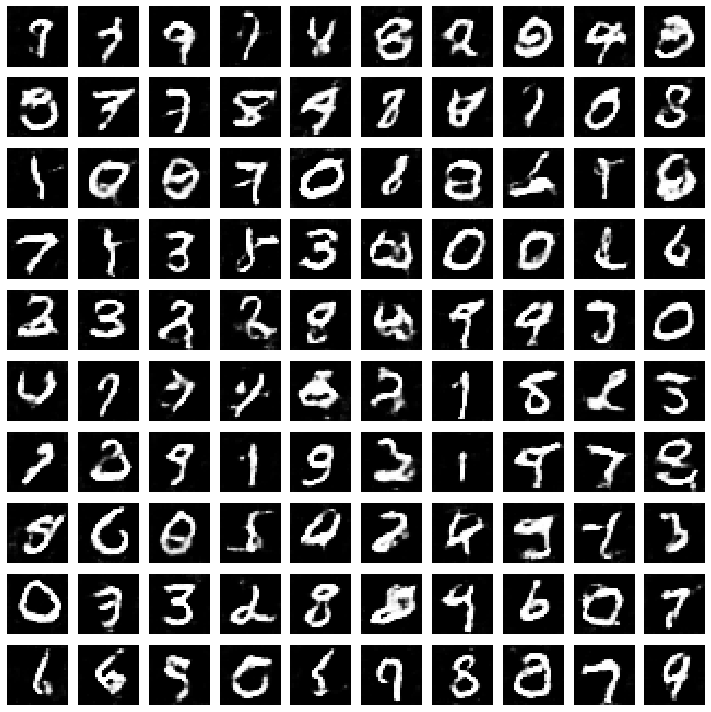

Epoch : 21, Discriminator Loss : 0.6858, Generator Loss : 0.8265
Epoch : 22, Discriminator Loss : 0.6858, Generator Loss : 0.8211
Epoch : 23, Discriminator Loss : 0.6855, Generator Loss : 0.8234
Epoch : 24, Discriminator Loss : 0.6850, Generator Loss : 0.8272
Epoch : 25, Discriminator Loss : 0.6835, Generator Loss : 0.8434
Epoch : 26, Discriminator Loss : 0.6838, Generator Loss : 0.8291
Epoch : 27, Discriminator Loss : 0.6833, Generator Loss : 0.8315
Epoch : 28, Discriminator Loss : 0.6831, Generator Loss : 0.8337
Epoch : 29, Discriminator Loss : 0.6825, Generator Loss : 0.8365
Epoch : 30, Discriminator Loss : 0.6818, Generator Loss : 0.8416


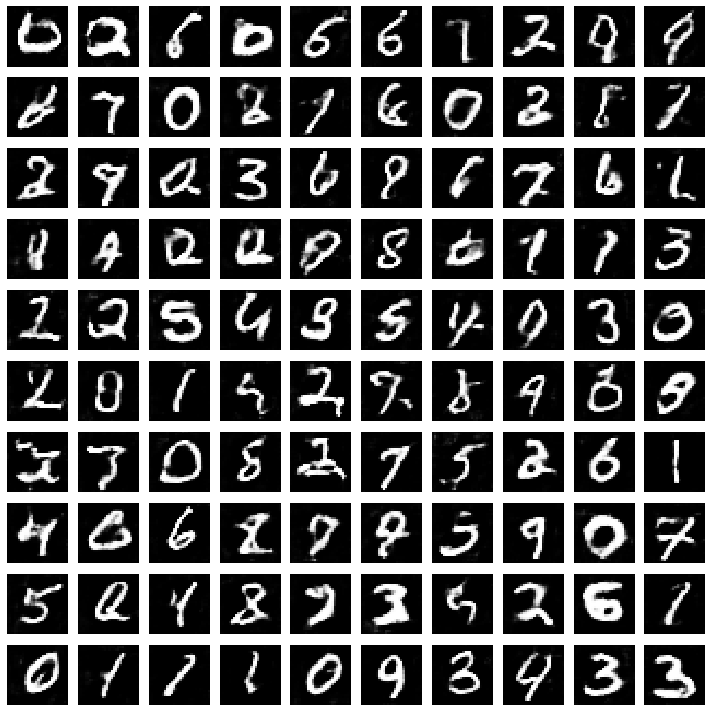

Epoch : 31, Discriminator Loss : 0.6813, Generator Loss : 0.8408
Epoch : 32, Discriminator Loss : 0.6801, Generator Loss : 0.8515
Epoch : 33, Discriminator Loss : 0.6799, Generator Loss : 0.8454
Epoch : 34, Discriminator Loss : 0.6790, Generator Loss : 0.8473
Epoch : 35, Discriminator Loss : 0.6787, Generator Loss : 0.8559
Epoch : 36, Discriminator Loss : 0.6774, Generator Loss : 0.8539
Epoch : 37, Discriminator Loss : 0.6769, Generator Loss : 0.8651
Epoch : 38, Discriminator Loss : 0.6761, Generator Loss : 0.8612
Epoch : 39, Discriminator Loss : 0.6749, Generator Loss : 0.8638
Epoch : 40, Discriminator Loss : 0.6741, Generator Loss : 0.8685


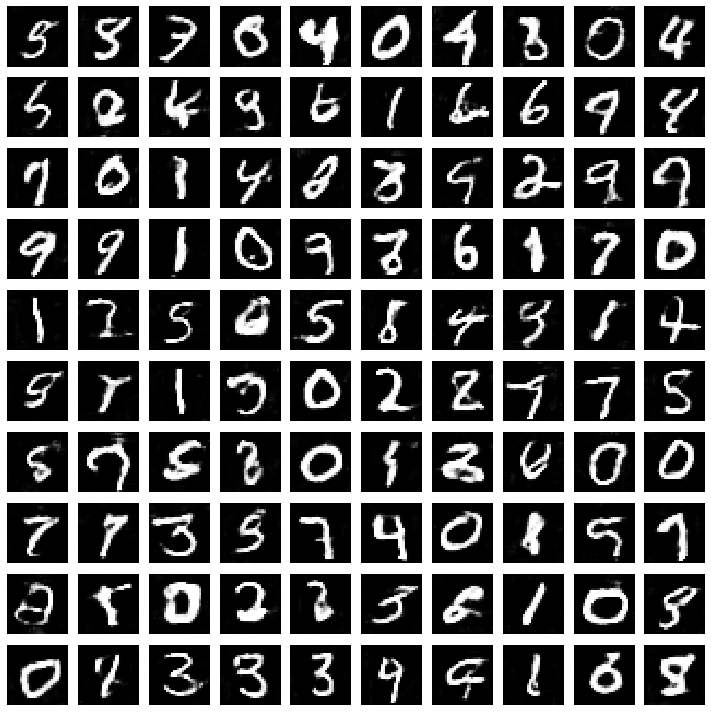

Epoch : 41, Discriminator Loss : 0.6735, Generator Loss : 0.8733
Epoch : 42, Discriminator Loss : 0.6722, Generator Loss : 0.8771
Epoch : 43, Discriminator Loss : 0.6711, Generator Loss : 0.8824
Epoch : 44, Discriminator Loss : 0.6700, Generator Loss : 0.8865
Epoch : 45, Discriminator Loss : 0.6694, Generator Loss : 0.8892
Epoch : 46, Discriminator Loss : 0.6688, Generator Loss : 0.8947
Epoch : 47, Discriminator Loss : 0.6676, Generator Loss : 0.8984
Epoch : 48, Discriminator Loss : 0.6662, Generator Loss : 0.9002
Epoch : 49, Discriminator Loss : 0.6649, Generator Loss : 0.9073
Epoch : 50, Discriminator Loss : 0.6638, Generator Loss : 0.9110


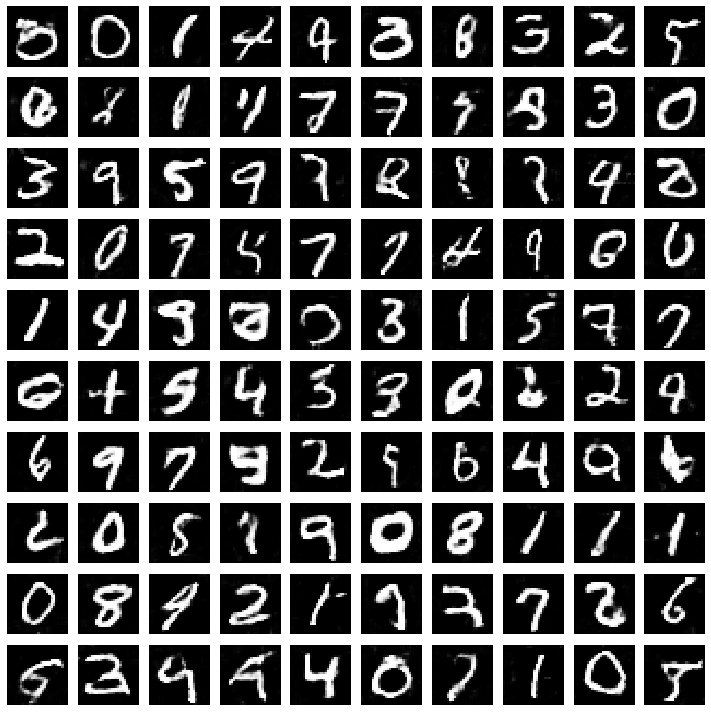

In [44]:
d_losses = []
g_losses = []
for epoch in range(TOTAL_EPOCHS):
  epoch_d_loss = 0.0
  epoch_g_loss = 0.0
  # Mini Batch Stochastic Gradient Descent
  for step in range(NO_OF_BATCHES):
    # For training Discriminator use 50% Real Data + 50% Fake Data
    # Real Data X
    idx = np.random.randint(0,X_Train.shape[0],HALF_BATCH)
    real_imgs = X_Train[idx]
    
    # Fake Data Y
    noise = np.random.normal(0,1,size=(HALF_BATCH,NOISE_DIM))
    fake_imgs = generator.predict(noise)
    
    # Labels
    real_y = np.ones((HALF_BATCH,1))*0.9 # One sided Label Smoothing
    fake_y = np.zeros((HALF_BATCH,1))

    # Training the Discriminator
    d_loss_real = discriminator.train_on_batch(real_imgs,real_y)
    d_loss_fake = discriminator.train_on_batch(fake_imgs,fake_y)
    d_loss = 0.5*d_loss_real + 0.5*d_loss_fake
    epoch_d_loss += d_loss

    # Training the Generator (Frozen Discriminator)
    noise = np.random.normal(0,1,size=(BATCH_SIZE,NOISE_DIM))
    ground_truth_y = np.ones((BATCH_SIZE,1))
    g_loss = model.train_on_batch(noise,ground_truth_y)
    epoch_g_loss += g_loss
    
  print('Epoch : %d, Discriminator Loss : %.4f, Generator Loss : %.4f'%(epoch+1,epoch_d_loss/NO_OF_BATCHES,epoch_g_loss/NO_OF_BATCHES))
  d_losses.append(epoch_d_loss/NO_OF_BATCHES)
  g_losses.append(epoch_g_loss/NO_OF_BATCHES)
  if (epoch+1)%10==0:
   save_imgs(epoch)

### Plotting The Loss

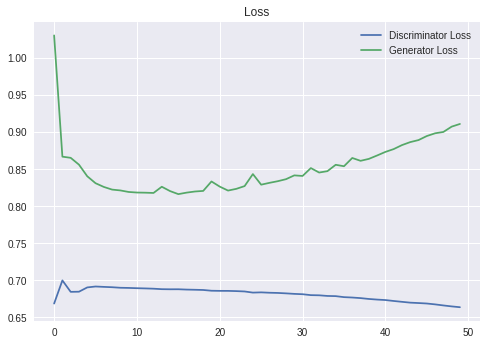

In [45]:
plt.plot(d_losses,label="Discriminator Loss")
plt.plot(g_losses,label="Generator Loss")
plt.legend()
plt.title('Loss')
plt.show()